In [1]:
print("Hello World")

Hello World


In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")


In [3]:
from langchain_tavily import TavilySearch

web_search  = TavilySearch(max_results=3)
web_search_results = web_search.invoke("Who is the mayor of NYC?")

print(web_search_results["results"][0]["content"])












Eric Adams (born September 1, 1960, Brooklyn, New York, U.S.) is the 110th mayor of New York City, a position he has held since 2022. Adams joined the New York City transit police in 1984 and later became a New York Police Department officer when the two departments merged. New York City belongs to the people that [were] here and made New York City what it is.” However, the New York Daily News reported that by that time, Adams had collected more than $800,000 from the real estate industry and donors who lived outside the city for the mayoral campaign he planned to launch later that year. The prosecutors said that after Adams became mayor, a Turkish official told him it was “his turn to repay.” They said Adams pressured New York’s fire department to approve a new Turkish consular building without a fire inspection.


In [4]:
from langgraph.prebuilt import create_react_agent
research_agent = create_react_agent(
    model = "openai:gpt-4.1",
    tools = [web_search],
    prompt = (
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name = "research_agent",
)

In [5]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [6]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "Who is the mayor of NYC?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_sWxLfPyZ6vYSD304gnBii4Il)
 Call ID: call_sWxLfPyZ6vYSD304gnBii4Il
  Args:
    query: current mayor of New York City
    search_depth: basic


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "current mayor of New York City", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Office of the Mayor | Mayor's Bio | City of New York - NYC.gov", "url": "https://www.nyc.gov/office-of-the-mayor/bio.page", "content": "Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. He gave voice to a diverse coalition of working families in all five boroughs and is leading the fight to bring back New York City's ec

In [7]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b

def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b

def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model = "openai:gpt-4.1",
    tools = [add, multiply, divide],
    prompt = (
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name = "math_agent",
)

In [9]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "What is (3+5)*2?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (call_owuWWlDbSK1gfRjapBWsCz32)
 Call ID: call_owuWWlDbSK1gfRjapBWsCz32
  Args:
    a: 3
    b: 5


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  multiply (call_dimoPcaMBr53Y2NbbGQiqhWu)
 Call ID: call_dimoPcaMBr53Y2NbbGQiqhWu
  Args:
    a: 8
    b: 2


Update from node tools:


================================= Tool Message =================================
Name: multiply

16.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

16




In [12]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(    
    model = init_chat_model("openai:gpt-4.1"),
    agents = [research_agent, math_agent],
    prompt = (
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
        ),
    add_handoff_back_messages =True,
    output_mode= "full_history"
).compile()

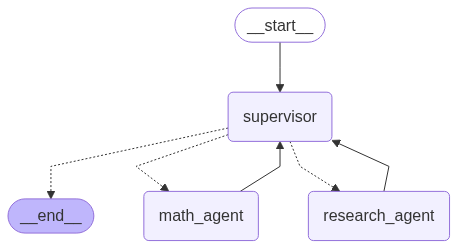

In [13]:
from IPython.display import Image, display
display(Image(supervisor.get_graph().draw_mermaid_png()))

In [14]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

The US GDP in 2024 is estimated at $22.67 trillion, and New York state's GDP is estimated at $2.297 trilli